### Howto


1. Decide if wanting to process the data and evaluate the same as CRT-Net paper, ie allow whatever label classes are in the data, but for each sample, just pick the first diagnosis OR do it PhysioNet competition style where only samples from a certain number of labels (as per csv file) are used but also each sample can have multiple labels
1. If you want CRT-Net style, run the cell where data is loaded with load_data given the argument adjust_classes_for_physionet as false. This will produce three file, the data samples themselves, the one hot encoded labels (only one per sample) and the discovered class names, to make it easier later to translate on hot labels to readable class names
1. If you want PhysioNet style, run cell with load_data given the argument adjust_classes_for_physionet as true
1. Run the cell that creates the train/evaluate functions plus creates the baseline crt_net model
1. Run other cells to create other models
1. Change the cell to read whatever numpy datafiles you like, and train/evaluate. It will work out whether to do multilabel or single label based on the onehot encoding


The below reads .hea and .mat file pairs and then :

- Standardises the sample lengths to the most common length (unless overridden), and sampling frequency to the most common frequency.
- One hot encodes the diagnostic class label, either picking the first "primary" label, or encoding all labels. The first case is consistency with the CRT-Net paper, the second for consistency with PhysioNet challenge
- To also be consistent with the PhysioNet challenge, it is also catered to restrict the classes to a certain specified set (via csv file), and also to ensure the "normal" class is always present



In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
import wfdb
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix


china_to_snomed = {
    '7':'164884008',
    '2':'164889003',
    '4':'164909002',
    '9':'164931005',
    '3':'270492004',
    '6':'284470004',
    '1':'426783006',
    '8':'429622005',
    '5':'59118001'
}

def read_records(record_files, csv_file_path=None):
    records = []
    labels = []

    if (csv_file_path is not None):
        df = pd.read_csv(csv_file_path)

    for record_file in record_files:
        record = wfdb.rdrecord(record_file)

        if(csv_file_path is not None):
            recording_id = record.file_name[0].split('.')[0]  # Assuming the recording ID is in the file name
        
            # Extract the First_label for the corresponding recording (numbner) and map it longer number
            first_label_str = df[df['Recording'] == recording_id]['First_label'].astype(str).values[0]
            first_label_mapped = china_to_snomed[first_label_str]
            
            # append a list with the first label
            labels.append([first_label_mapped])
        else:
            for comment in record.comments:
                if comment.startswith('Dx') or comment.startswith(' Dx'):
                    dxs = set(arr.strip() for arr in comment.split(': ')[1].split(','))
                    labels.append(dxs)
                    
        records.append(wfdb.rdrecord(record_file))
    return records, labels


def create_one_hot_labels(all_labels, target_classes, num_recordings):
    discard_index = list()
    labels = np.zeros((num_recordings, len(target_classes)))  # , dtype=np.bool)
    for i in range(num_recordings):
        dxs = all_labels[i]
        flag = np.zeros((1, len(dxs)), dtype=bool)
        count = 0
        for dx in dxs:
            if dx in target_classes:
                j = target_classes.index(dx)
                labels[i, j] = 1
                flag[0, count] = True

            count += 1

        # note any recordings that don't have any of the classes we are looking for
        if np.any(flag) == False:
            discard_index.append(i)

    return labels, discard_index

def get_unique_classes(all_labels, valid_classes=None):

    classes2 = list()
    for i in range(len(all_labels)):
        dxs = all_labels[i]
        for dx in dxs:
            if valid_classes is None or dx in valid_classes:
                classes2.append(dx)

    classes3 = list()
    for x in classes2:
        if x not in classes3:
            classes3.append(x)

    classes3 = sorted (classes3)
    return classes3

def find_records(directory):
    record_files = []
    for dirpath, _, filenames in os.walk(directory):
        for f in sorted(filenames):
            file_path = os.path.join(dirpath, f)
            if os.path.isfile(file_path) and not f.lower().startswith('.'):
                file, ext = os.path.splitext(file_path)
                if ext.lower() == '.hea':
                    record_files.append(file)
    if record_files:
        return record_files
    else:
        raise IOError('No record files found.')

def filter(data, labels, index):
    labels = [labels[i] for i in range(len(labels)) if i not in index]
    data = [data[i] for i in range(len(data)) if i not in index]
    return labels, data

def consolidate_equivalent_classes(one_hot_encoded_labels, unique_classes):
    equivalent_classes_collection = [['713427006', '59118001'], ['284470004', '63593006'], ['427172004', '17338001']]

    # For each set of equivalent class, use only one class as the representative class for the set and discard the other classes in the set.
    # The label for the representative class is positive if any of the labels in the set is positive.
    remove_classes = list()
    remove_indices = list()
    for equivalent_classes in equivalent_classes_collection:
        equivalent_classes = [x for x in equivalent_classes if x in unique_classes]
        if len(equivalent_classes)>1:
            other_classes = equivalent_classes[1:]
            equivalent_indices = [unique_classes.index(x) for x in equivalent_classes]
            representative_index = equivalent_indices[0]
            other_indices = equivalent_indices[1:]

            one_hot_encoded_labels[:, representative_index] = np.any(one_hot_encoded_labels[:, equivalent_indices], axis=1)
            remove_classes += other_classes
            remove_indices += other_indices

    for x in remove_classes:
        unique_classes.remove(x)
    one_hot_encoded_labels = np.delete(one_hot_encoded_labels, remove_indices, axis=1)

    return one_hot_encoded_labels, unique_classes

def set_labels_to_normal_if_none_other(labels, unique_classes, normal_class):
    # If the labels are negative for all classes, then change the label for the normal class to positive.
    normal_index = unique_classes.index(normal_class)
    for i in range(len(labels)):
        num_positive_classes = np.sum(labels[i, :])
        if num_positive_classes==0:
            labels[i, normal_index] = 1

    return labels

def ensure_normal_class(unique_classes, normal_class):
    if normal_class not in unique_classes:
        unique_classes.add(normal_class)
        print('- The normal class {} is not one of the label classes, so it has been automatically added, but please check that you chose the correct normal class.'.format(normal_class))
    unique_classes = sorted(unique_classes)
    return unique_classes

def read_scored_classes():
    scored = list()
    with open('dx_mapping_scored.csv', 'r') as f:
        for l in f:
            dxs = (l.split(','))
            scored.append(dxs[1])
    return (sorted(scored[1:]))

def filter_out(one_hot_encoded_labels, records, discard_index):
    one_hot_encoded_labels = [one_hot_encoded_labels[i] for i in range(len(one_hot_encoded_labels)) if i not in discard_index]
    records = [records[i] for i in range(len(records)) if i not in discard_index]

    return one_hot_encoded_labels, records

def load_records(record_file_list, adjust_classes_for_physionet, csv_file, normal_class):
        
    if len(record_file_list) == 0:
        raise ValueError('No record files found.')

    num_recordings = len(record_file_list)

    records, all_labels = read_records(record_file_list, csv_file)

    scored = None
    if adjust_classes_for_physionet:
        scored = read_scored_classes()

    unique_classes = get_unique_classes(all_labels, scored)

    if (normal_class is not None):
        unique_classes = ensure_normal_class(unique_classes, normal_class)
    
    one_hot_encoded_labels, discard_index = create_one_hot_labels(all_labels, unique_classes, num_recordings)

    if (adjust_classes_for_physionet):
        one_hot_encoded_labels, unique_classes = consolidate_equivalent_classes(one_hot_encoded_labels, unique_classes)
    
    if (normal_class is not None):
        one_hot_encoded_labels = set_labels_to_normal_if_none_other(one_hot_encoded_labels, unique_classes, normal_class)
    
    one_hot_encoded_labels, records = filter_out(one_hot_encoded_labels, records, discard_index)

    return one_hot_encoded_labels, records, unique_classes

def standardise_length(data, target_length):
    number_of_leads = data.shape[0]
    
    if len(data[0])<=target_length:
        ext= np.zeros([number_of_leads,target_length])
        for i in range(0,number_of_leads):
            ext[i][0:len(data[i])]=data[i]
        return ext.T  
    else:
        cut = np.zeros([number_of_leads,target_length])
        for i in range(number_of_leads):
            tocut = len(data[0])- target_length
            cut[i] = data[i][tocut:]
        return cut.T 

def resample(data, src_frq, trg_frq):

    if src_frq == trg_frq:
        return data

    N_src = data.shape[0]
    N_trg = int(N_src * trg_frq / src_frq)
    
    resampled = np.zeros((N_trg, data.shape[1]), dtype='float32')
    for i in range(data.shape[1]):
        resampled[:,i] = np.interp(np.linspace(0, N_src, N_trg), np.arange(N_src), data[:, i])
        
    return resampled

def standardise_data_samples(records, fixed_sample_length=None):
    standardised_data = list()

    # find the most common fs
    fss = [record.fs for record in records]

    target_fs = max(set(fss), key=fss.count)

    # find the most common sig_len
    sig_lens = [record.sig_len for record in records]

    if (fixed_sample_length is not None):
        target_length = fixed_sample_length
    else:
        target_length = max(set(sig_lens), key=sig_lens.count)

    for i in range(len(records)):
        datum = records[i].p_signal.T
        datum = resample(datum,records[i].fs, target_fs)
        datum = standardise_length(datum, target_length)
        standardised_data.append(datum)

    return standardised_data

def load_data(input_directory, adjust_classes_for_physionet=False, csv_file=None, normal_class=None, fixed_sample_length=None):
    record_file_list = find_records(input_directory)
    
    one_hot_encoded_labels, records, classes = load_records(record_file_list, adjust_classes_for_physionet, csv_file=csv_file, normal_class=normal_class)
    samples = standardise_data_samples(records, fixed_sample_length=fixed_sample_length)
            
    one_hot_encoded_labels = np.stack(one_hot_encoded_labels, axis =0)
    samples = np.stack(samples, axis =0)

    return one_hot_encoded_labels, samples, classes



Run below to get an numpy output of samples, single one hot encoded label and the class names for the China 2018 data as used by the CRT-Net paper.

In [ ]:
output_directory = 'data'
input_directory = 'cpsc_2018'
    
one_hot_encoding_labels, samples, classes = load_data(input_directory, adjust_classes_for_physionet=False,  csv_file='REFERENCE.csv', fixed_sample_length=3000)

# maps SNOMED CT codes to classes
snomed_to_abbreviation = {
    '164884008': 'PVC',
    '164889003': 'AF',
    '164909002': 'LBBB',
    '164931005': 'STE',
    '270492004': 'IAVB',
    '284470004': 'PAC',
    '426783006': 'N',
    '429622005': 'STD',
    '59118001': 'RBBB'
}

# map classes to abbreviations
mapped_abbreviations = [snomed_to_abbreviation.get(code, None) for code in classes]

# save the data to a file
np.save(os.path.join(output_directory, 'cpsc_2018_crtnet_singlelabel_samples.npy'), samples)
np.save(os.path.join(output_directory, 'cpsc_2018_crtnet_singlelabel_one_hot_encoding_labels.npy'), one_hot_encoding_labels)
np.save(os.path.join(output_directory, 'cpsc_2018_crtnet_singlelabel_classes.npy'), mapped_abbreviations)


In [3]:
output_directory = 'data'
input_directory = 'cpsc_2018'
    
one_hot_encoding_labels, samples, classes = load_data(input_directory, adjust_classes_for_physionet=False)

# maps SNOMED CT codes to classes
snomed_to_abbreviation = {
    '164884008': 'PVC',
    '164889003': 'AF',
    '164909002': 'LBBB',
    '164931005': 'STE',
    '270492004': 'IAVB',
    '284470004': 'PAC',
    '426783006': 'N',
    '429622005': 'STD',
    '59118001': 'RBBB'
}

# map classes to abbreviations
mapped_abbreviations = [snomed_to_abbreviation.get(code, None) for code in classes]

# save the data to a file
np.save(os.path.join(output_directory, 'cpsc_2018_crtnet_multilabel_samples.npy'), samples)
np.save(os.path.join(output_directory, 'cpsc_2018_crtnet_multilabel_one_hot_encoding_labels.npy'), one_hot_encoding_labels)
np.save(os.path.join(output_directory, 'cpsc_2018_crtnet_multilabel_classes.npy'), mapped_abbreviations)

import os
import numpy as np
from sklearn.model_selection import train_test_split
import wfdb
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix

# get stats of the data
samples = np.load(os.path.join("data", 'cpsc_2018_crtnet_multilabel_samples.npy'))
one_hot_encoding_labels = np.load(os.path.join("data", 'cpsc_2018_crtnet_multilabel_one_hot_encoding_labels.npy'))
classes = np.load(os.path.join("data", 'cpsc_2018_crtnet_multilabel_classes.npy'))

print(f"Number of samples: {samples.shape[0]}")
print(f"Number of leads: {samples.shape[2]}")
print(f"Number of classes: {one_hot_encoding_labels.shape[1]}")
print(f"Classes: {classes}")

# get counts of each class
class_counts = np.sum(one_hot_encoding_labels, axis=0)
class_counts = dict(zip(classes, class_counts))
print(f"Class counts: {class_counts}")

NameError: name 'load_data' is not defined

Run below to get an numpy output of samples, multilabel one hot encoded labels and the class names for any PhysioNet data. This data will be restricted to the PhysioNet challenge list of classes and will be guaranteed to include the "normal" class.

The can be run on any set of sets of PhysioNet data, including China 2018, PTB-XL etc

In [ ]:
output_directory = 'data'
input_directory = 'cpsc_2018'
    
one_hot_encoding_labels, samples, classes = load_data(input_directory, adjust_classes_for_physionet=True, normal_class='426783006')
# save the data to a file
np.save(os.path.join(output_directory, 'cpsc_2018_physionet_samples.npy'), samples)
np.save(os.path.join(output_directory, 'cpsc_2018_physionet_one_hot_encoding_labels.npy'), one_hot_encoding_labels)
np.save(os.path.join(output_directory, 'cpsc_2018_physionet_classes.npy'), classes)


Load data from numpy files, then train and evaluate of whichever model, by default the baseline CRT-Net

The loss function depends on whether doing multilabel or single label classification, which is inferred from the data (ie if each sample has exlusive one hot encoding or multiple)

The class names are read to label the outputs more clearly based on SNOMED, vs just having unlabeled one-hot encoding position

2024-05-14 18:08:53,742 - Physical devices found: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2024-05-14 18:08:53,743 - Memory growth of device 0: True
2024-05-14 18:09:55,710 - Training completed
2024-05-14 18:10:02,664 - Model Method: create_crtnet_alternate
              precision    recall  f1-score   support

         PVC       0.00      0.00      0.00       317
          AF       0.00      0.00      0.00       564
        LBBB       0.00      0.00      0.00       100
         STE       0.00      0.00      0.00        95
        IAVB       0.00      0.00      0.00       304
         PAC       0.00      0.00      0.00       271
           N       0.00      0.00      0.00       422
         STD       0.00      0.00      0.00       417
        RBBB       0.00      0.00      0.00       830

   micro avg       0.00      0.00      0.00      3320
   macro avg       0.00      0.00      0.00      3320
weighted avg       0.00      0.00      0.00      3320
 samples avg

Epoch 1/2
25/25 [==============================] - 16s 205ms/step - loss: 0.1299 - accuracy: 0.1774 - f1_score: 0.0890 - val_loss: 0.0958 - val_accuracy: 0.2200 - val_f1_score: 0.0470 - lr: 1.0000e-04
Epoch 2/2
97/97 [==============================] - 1s 15ms/step


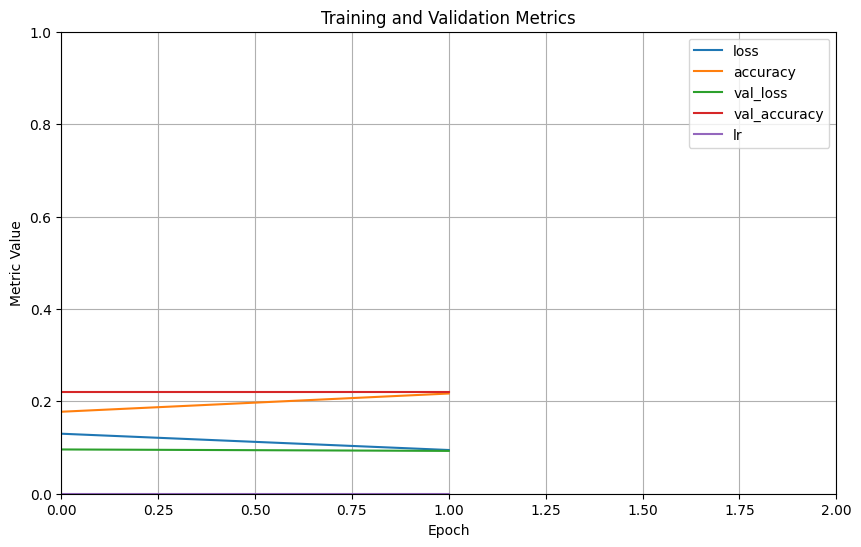

2024-05-14 18:10:03,095 - Hamming Loss: 0.1192
2024-05-14 18:10:03,096 - Subset Accuracy: 0.0000
2024-05-14 18:10:03,096 - Micro F1 Score: 0.0000
2024-05-14 18:10:03,097 - Macro F1 Score: 0.0000
2024-05-14 18:10:03,097 - Weighted F1 Score: 0.0000
2024-05-14 18:10:03,097 - AUC-PR: 0.1192
2024-05-14 18:10:03,098 - Evaluate results: [0.09268403798341751, 0.22003230452537537, array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.42292994], dtype=float32)]
2024-05-14 18:10:03,099 - Evaluated Validation Loss: 0.0927
2024-05-14 18:10:03,099 - Evaluated Validation Accuracy: 0.2200
2024-05-14 18:10:24,844 - Training completed
2024-05-14 18:10:31,771 - Model Method: create_crtnet_alternate
              precision    recall  f1-score   support

         PVC       0.00      0.00      0.00       314
          AF       0.00      0.00      0.00       529
        LBBB       0.00      0.00      0.00       116
         STE       0.00      0.00   

Epoch 1/2
25/25 [==============================] - 16s 206ms/step - loss: 0.1119 - accuracy: 0.1816 - f1_score: 0.0901 - val_loss: 0.0976 - val_accuracy: 0.2275 - val_f1_score: 0.0477 - lr: 1.0000e-04
Epoch 2/2
97/97 [==============================] - 1s 15ms/step


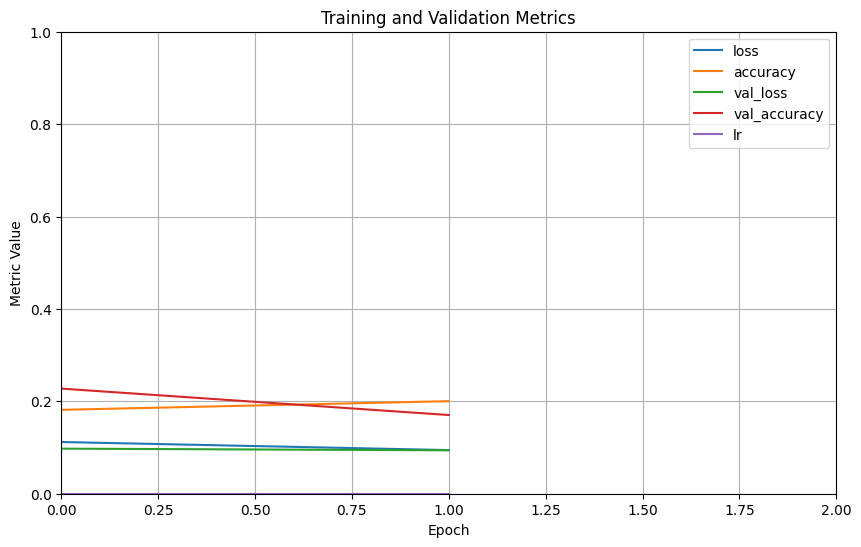

2024-05-14 18:10:32,208 - Hamming Loss: 0.1186
2024-05-14 18:10:32,209 - Subset Accuracy: 0.0000
2024-05-14 18:10:32,209 - Micro F1 Score: 0.0000
2024-05-14 18:10:32,210 - Macro F1 Score: 0.0000
2024-05-14 18:10:32,210 - Weighted F1 Score: 0.0000
2024-05-14 18:10:32,210 - AUC-PR: 0.1186
2024-05-14 18:10:32,211 - Evaluate results: [0.09398549795150757, 0.17032967507839203, array([0.       , 0.2920232, 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       ], dtype=float32)]
2024-05-14 18:10:32,211 - Evaluated Validation Loss: 0.0940
2024-05-14 18:10:32,212 - Evaluated Validation Accuracy: 0.1703
2024-05-14 18:10:32,214 - Metrics (Mean ± Std Dev):
2024-05-14 18:10:32,214 - hl: 0.1189 ± 0.0003
2024-05-14 18:10:32,215 - sa: 0.0000 ± 0.0000
2024-05-14 18:10:32,215 - micro_f1: 0.0000 ± 0.0000
2024-05-14 18:10:32,215 - macro_f1: 0.0000 ± 0.0000
2024-05-14 18:10:32,216 - weighted_f1: 0.0000 ± 0.0000
2024-05-14 18:10:32,216 - auc_pr: 0.1189 ± 0.0003
2024-05-14 18:10:3

In [13]:
import tensorflow.keras as keras
from tensorflow.keras import utils
import os
import tensorflow as tf
import datetime
import numpy as np
from src import train_and_evaluate
from importlib import reload
reload(train_and_evaluate)
from src import crtnet_models
reload(crtnet_models)
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

    
stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=0.00001)

# load the data from the file
samples = np.load(os.path.join("data", 'cpsc_2018_crtnet_multilabel_samples.npy'))
one_hot_encoding_labels = np.load(os.path.join("data", 'cpsc_2018_crtnet_multilabel_one_hot_encoding_labels.npy'))
classes = np.load(os.path.join("data", 'cpsc_2018_crtnet_multilabel_classes.npy'))

is_multilabel = any(sum(row) > 1 for row in one_hot_encoding_labels)

create_crtnet_method = crtnet_models.create_crtnet_alternate

train_and_evaluate.train_and_evaluate_model(
    create_crtnet_method,
    samples=samples,
    one_hot_encoding_labels=one_hot_encoding_labels,
    callbacks=[reduce_lr, stopping],
    epochs=2,
    batch_size=128,
    classes=classes,
    folds=2,
    number_of_leads=samples.shape[2],
    is_multilabel=is_multilabel,
    initial_learning_rate=0.0001
)



Physical devices found: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Memory growth of device 0: True
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 12)]        0         
                                                                 
 vgg_net (VGGNet)            (None, None, 128)         448256    
                                                                 
 bi_gru (BiGRU)              (None, None, 256)         198144    
                                                                 
 stacked_transformer_encode  (None, None, 256)         1583104   
 r (StackedTransformerEncod                                      
 er)                                                             
                                                                 
 global_average_pooling1d (  (None, 256)               0         
 Glo

2024-05-15 04:12:27,709 - None
2024-05-15 04:12:46,889 - Training completed
2024-05-15 04:12:51,619 - Model Method: create_crtnet_original
              precision    recall  f1-score   support

         PVC       0.00      0.00      0.00       317
          AF       0.00      0.00      0.00       564
        LBBB       0.00      0.00      0.00       100
         STE       0.00      0.00      0.00        95
        IAVB       0.00      0.00      0.00       304
         PAC       0.00      0.00      0.00       271
           N       0.14      1.00      0.24       422
         STD       0.00      0.00      0.00       417
        RBBB       0.27      1.00      0.42       830

   micro avg       0.20      0.38      0.26      3320
   macro avg       0.04      0.22      0.07      3320
weighted avg       0.08      0.38      0.14      3320
 samples avg       0.20      0.38      0.26      3320

2024-05-15 04:12:51,622 - Class 'PVC' Accuracy: 0.8976
Class 'AF' Accuracy: 0.8178
Class 'LBBB' Accura

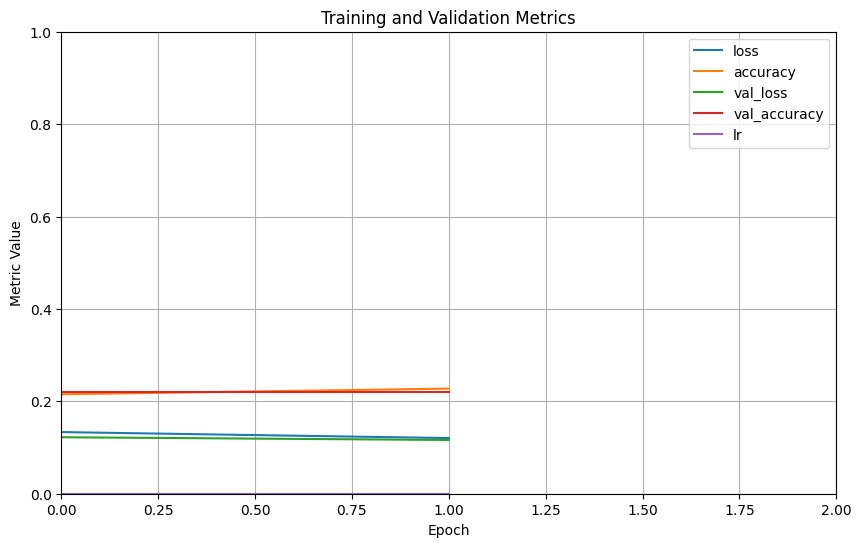

2024-05-15 04:12:51,962 - Hamming Loss: 0.2515
2024-05-15 04:12:51,963 - Subset Accuracy: 0.0000
2024-05-15 04:12:51,963 - Micro F1: 0.2633
2024-05-15 04:12:51,964 - Macro F1: 0.0737
2024-05-15 04:12:51,964 - Weighted F1: 0.1362
2024-05-15 04:12:51,964 - Auc Pr: 0.1505
2024-05-15 04:12:51,965 - Eval Loss: 0.1163
2024-05-15 04:12:51,965 - Eval Accuracy: 0.2200
2024-05-15 04:12:52,775 - None
2024-05-15 04:13:13,578 - Training completed
2024-05-15 04:13:18,261 - Model Method: create_crtnet_original
              precision    recall  f1-score   support

         PVC       0.10      1.00      0.18       314
          AF       0.00      0.00      0.00       529
        LBBB       0.00      0.00      0.00       116
         STE       0.00      0.00      0.00        93
        IAVB       0.11      1.00      0.20       343
         PAC       0.09      1.00      0.17       290
           N       0.00      0.00      0.00       399
         STD       0.00      0.00      0.00       372
        RBBB

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 12)]        0         
                                                                 
 vgg_net (VGGNet)            (None, None, 128)         448256    
                                                                 
 bi_gru (BiGRU)              (None, None, 256)         198144    
                                                                 
 stacked_transformer_encode  (None, None, 256)         1583104   
 r (StackedTransformerEncod                                      
 er)                                                             
                                                                 
 global_average_pooling1d (  (None, 256)               0         
 GlobalAveragePooling1D)                                         
                                                             

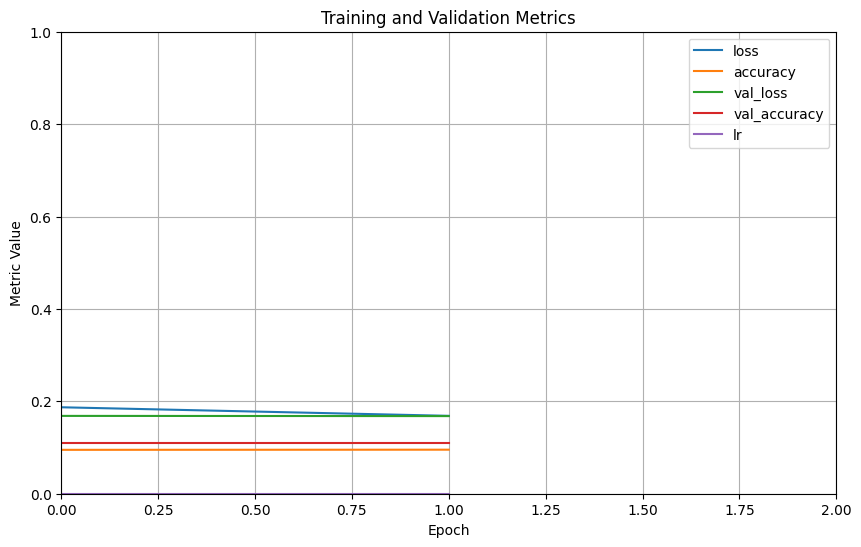

2024-05-15 04:13:18,580 - Hamming Loss: 0.4342
2024-05-15 04:13:18,581 - Subset Accuracy: 0.0000
2024-05-15 04:13:18,582 - Micro F1: 0.2287
2024-05-15 04:13:18,582 - Macro F1: 0.1094
2024-05-15 04:13:18,583 - Weighted F1: 0.1633
2024-05-15 04:13:18,583 - Auc Pr: 0.1329
2024-05-15 04:13:18,583 - Eval Loss: 0.1680
2024-05-15 04:13:18,584 - Eval Accuracy: 0.1089
2024-05-15 04:13:18,588 - Metrics (Mean ± Std Dev):
2024-05-15 04:13:18,588 - hamming_loss: 0.3429 ± 0.0914
2024-05-15 04:13:18,589 - subset_accuracy: 0.0000 ± 0.0000
2024-05-15 04:13:18,589 - micro_f1: 0.2460 ± 0.0173
2024-05-15 04:13:18,590 - macro_f1: 0.0915 ± 0.0179
2024-05-15 04:13:18,590 - weighted_f1: 0.1498 ± 0.0135
2024-05-15 04:13:18,590 - auc_pr: 0.1417 ± 0.0088
2024-05-15 04:13:18,591 - eval_loss: 0.1422 ± 0.0258
2024-05-15 04:13:18,591 - eval_accuracy: 0.1645 ± 0.0556
2024-05-15 04:13:19,799 - None
2024-05-15 04:13:41,106 - Training completed
2024-05-15 04:13:46,112 - Model Method: create_crtnet_alternate
            

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 12)]        0         
                                                                 
 vgg_net (VGGNet)            (None, None, 128)         2414976   
                                                                 
 bi_gru (BiGRU)              (None, None, 256)         198144    
                                                                 
 stacked_transformer_encode  (None, None, 256)         1583104   
 r (StackedTransformerEncod                                      
 er)                                                             
                                                                 
 global_average_pooling1d (  (None, 256)               0         
 GlobalAveragePooling1D)                                         
                                                             

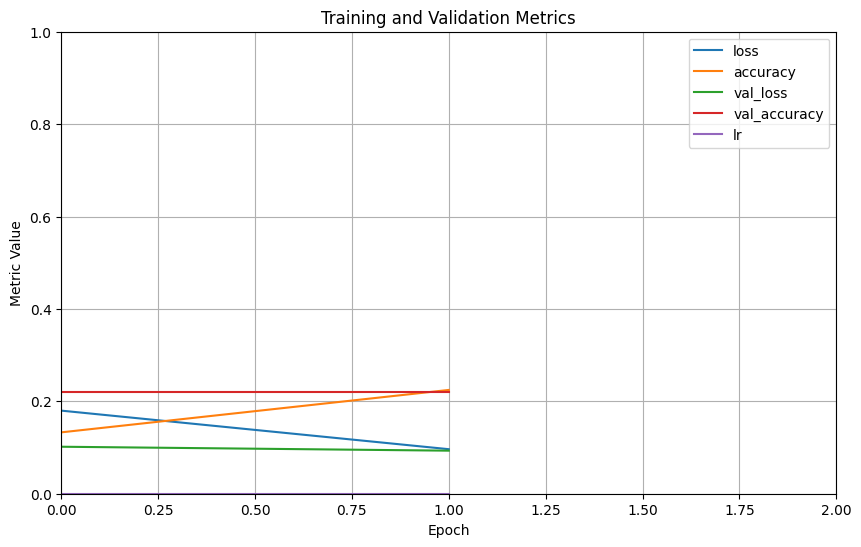

2024-05-15 04:13:46,432 - Hamming Loss: 0.1192
2024-05-15 04:13:46,432 - Subset Accuracy: 0.0000
2024-05-15 04:13:46,433 - Micro F1: 0.0000
2024-05-15 04:13:46,433 - Macro F1: 0.0000
2024-05-15 04:13:46,434 - Weighted F1: 0.0000
2024-05-15 04:13:46,434 - Auc Pr: 0.1192
2024-05-15 04:13:46,434 - Eval Loss: 0.0932
2024-05-15 04:13:46,435 - Eval Accuracy: 0.2200
2024-05-15 04:13:47,299 - None
2024-05-15 04:14:10,470 - Training completed
2024-05-15 04:14:16,431 - Model Method: create_crtnet_alternate
              precision    recall  f1-score   support

         PVC       0.00      0.00      0.00       314
          AF       0.00      0.00      0.00       529
        LBBB       0.00      0.00      0.00       116
         STE       0.00      0.00      0.00        93
        IAVB       0.00      0.00      0.00       343
         PAC       0.00      0.00      0.00       290
           N       0.00      0.00      0.00       399
         STD       0.00      0.00      0.00       372
        RBB

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 12)]        0         
                                                                 
 vgg_net (VGGNet)            (None, None, 128)         2414976   
                                                                 
 bi_gru (BiGRU)              (None, None, 256)         198144    
                                                                 
 stacked_transformer_encode  (None, None, 256)         1583104   
 r (StackedTransformerEncod                                      
 er)                                                             
                                                                 
 global_average_pooling1d (  (None, 256)               0         
 GlobalAveragePooling1D)                                         
                                                             

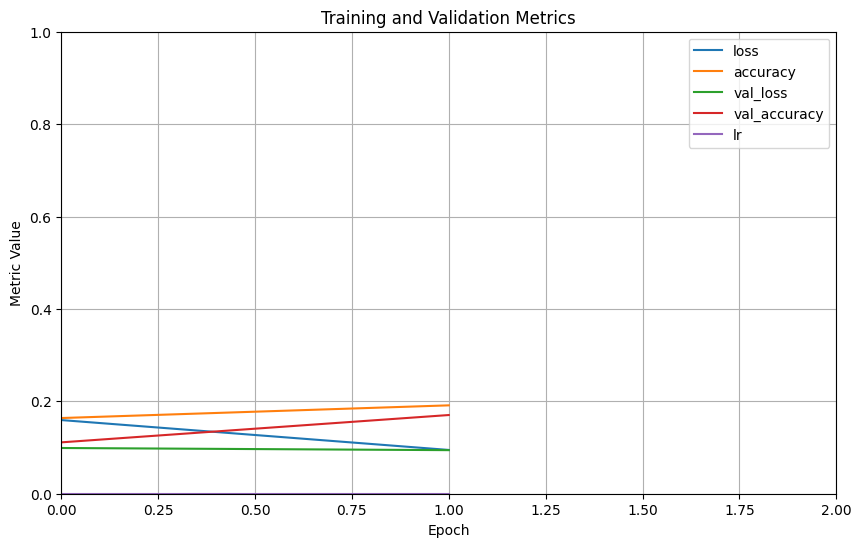

2024-05-15 04:14:16,858 - Hamming Loss: 0.1186
2024-05-15 04:14:16,859 - Subset Accuracy: 0.0000
2024-05-15 04:14:16,860 - Micro F1: 0.0000
2024-05-15 04:14:16,860 - Macro F1: 0.0000
2024-05-15 04:14:16,860 - Weighted F1: 0.0000
2024-05-15 04:14:16,860 - Auc Pr: 0.1186
2024-05-15 04:14:16,861 - Eval Loss: 0.0943
2024-05-15 04:14:16,861 - Eval Accuracy: 0.1703
2024-05-15 04:14:16,865 - Metrics (Mean ± Std Dev):
2024-05-15 04:14:16,865 - hamming_loss: 0.1189 ± 0.0003
2024-05-15 04:14:16,866 - subset_accuracy: 0.0000 ± 0.0000
2024-05-15 04:14:16,866 - micro_f1: 0.0000 ± 0.0000
2024-05-15 04:14:16,867 - macro_f1: 0.0000 ± 0.0000
2024-05-15 04:14:16,867 - weighted_f1: 0.0000 ± 0.0000
2024-05-15 04:14:16,867 - auc_pr: 0.1189 ± 0.0003
2024-05-15 04:14:16,868 - eval_loss: 0.0937 ± 0.0006
2024-05-15 04:14:16,868 - eval_accuracy: 0.1952 ± 0.0249


'output/run_data_20240515_041416.pkl'

In [3]:
import tensorflow.keras as keras
from tensorflow.keras import utils
import os
import tensorflow as tf
import numpy as np
from src import train_and_evaluate
from importlib import reload
reload(train_and_evaluate)
from src import crtnet_models
reload(crtnet_models)
import os
import datetime
import pickle

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

EPOCHS = 2
BATCH_SIZE = 128
INITIAL_LEARNING_RATE = 0.0001
OUTPUT_DIRECTORY = "output"

# Callback Constants
EARLY_STOPPING_MONITOR = 'val_loss'
EARLY_STOPPING_PATIENCE = 5
EARLY_STOPPING_RESTORE_BEST_WEIGHTS = True

REDUCE_LR_MONITOR = 'val_loss'
REDUCE_LR_FACTOR = 0.5
REDUCE_LR_PATIENCE = 4
REDUCE_LR_MIN_LR = 0.00001

# Define folds
FOLDS = 2

def save_run_data(run_data, directory=OUTPUT_DIRECTORY, filename=None):
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    if filename is None:
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"run_data_{timestamp}.pkl"
    
    filepath = os.path.join(directory, filename)
    
    with open(filepath, 'wb') as f:
        pickle.dump(run_data, f)
    
    return filepath

def load_run_data(filepath):
    with open(filepath, 'rb') as f:
        return pickle.load(f)

# Define the model creation methods
model_methods = [
    crtnet_models.create_crtnet_original,
    #crtnet_models.create_crtnet_our_transformer,
    #crtnet_models.create_crtnet_dense,
    #crtnet_models.create_crtnet_no_attn,
    #crtnet_models.create_crtnet_dense_noselu,
    crtnet_models.create_crtnet_alternate,
    #crtnet_models.create_crtnet_rwkv,
]

# Load data once
multilabel_data = {
    "samples": np.load(os.path.join("data", 'cpsc_2018_crtnet_multilabel_samples.npy')),
    "one_hot_encoding_labels": np.load(os.path.join("data", 'cpsc_2018_crtnet_multilabel_one_hot_encoding_labels.npy')),
    "classes": np.load(os.path.join("data", 'cpsc_2018_crtnet_multilabel_classes.npy'))
}

singlelabel_data = {
    "samples": np.load(os.path.join("data", 'cpsc_2018_crtnet_singlelabel_samples.npy')),
    "one_hot_encoding_labels": np.load(os.path.join("data", 'cpsc_2018_crtnet_singlelabel_one_hot_encoding_labels.npy')),
    "classes": np.load(os.path.join("data", 'cpsc_2018_crtnet_singlelabel_classes.npy'))
}


# Function to determine if labels are multilabel
def is_multilabel(labels):
    return any(sum(row) > 1 for row in labels)

data = multilabel_data
all_runs_data = []

# Loop through model methods, data types, and folds
for create_crtnet_method in model_methods:
    run_results = train_and_evaluate.train_and_evaluate_model(
        create_crtnet_method,
        samples=data["samples"],
        one_hot_encoding_labels=data["one_hot_encoding_labels"],
        callbacks=[
            keras.callbacks.EarlyStopping(monitor=EARLY_STOPPING_MONITOR, patience=EARLY_STOPPING_PATIENCE, restore_best_weights=EARLY_STOPPING_RESTORE_BEST_WEIGHTS),
            keras.callbacks.ReduceLROnPlateau(monitor=REDUCE_LR_MONITOR, factor=REDUCE_LR_FACTOR, patience=REDUCE_LR_PATIENCE, min_lr=REDUCE_LR_MIN_LR)
        ],
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        classes=data["classes"],
        folds=FOLDS,
        number_of_leads=data["samples"].shape[2],
        is_multilabel=is_multilabel(data["one_hot_encoding_labels"]),
        initial_learning_rate=INITIAL_LEARNING_RATE
    )

    run_data = {
        'create_crtnet_method': create_crtnet_method.__name__,
        'epochs': EPOCHS,
        'batch_size': BATCH_SIZE,
        'initial_learning_rate': INITIAL_LEARNING_RATE,
        'early_stopping': {
            'monitor': EARLY_STOPPING_MONITOR,
            'patience': EARLY_STOPPING_PATIENCE,
            'restore_best_weights': EARLY_STOPPING_RESTORE_BEST_WEIGHTS
        },
        'reduce_lr': {
            'monitor': REDUCE_LR_MONITOR,
            'factor': REDUCE_LR_FACTOR,
            'patience': REDUCE_LR_PATIENCE,
            'min_lr': REDUCE_LR_MIN_LR
        },
        'folds_data': run_results['folds_data'],
        'training_run_summary': run_results['training_run_summary']
    }

    all_runs_data.append(run_data)

save_run_data(all_runs_data)
